In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.models import Sequential

Firstly , making word vector. Downloaded word vector online. Making a vector corresponding to each word from the word embediing.

In [55]:
def read_glove_vector(path):
    fh = open(path,"r")
    lines=fh.readlines()
    words=set()
    word_to_vec={}
    for element in lines:
        modified_element=element.strip().split()
        word=modified_element[0]
        words.add(word)
#         print word
        word_to_vec[word]=np.array(modified_element[1:],dtype=np.float64)
    
    return words,word_to_vec

In [56]:
words,words_to_vec=read_glove_vector('glove.6B.50d.txt')#words is collection of unique words and word_to_vec is a dictionary

#### Word analogy using word emebeddings

Check similarity of two vector using cosine similarity

The basic rule of finding analaogy between four words say a,b,c and d i.e. a is to b as c is to d is
if we could find d such that embedding(a)-embedding(b)=embedding(c)-embedding(d).

In [57]:
def cosine_similarity(u,v):
    product=np.dot(u.T,v)
    norm_u = np.sqrt(np.sum(np.square(u)))
    norm_v = np.sqrt(np.sum(np.square(v)))
    cosine_similarity = product/(norm_u*norm_v)
    return cosine_similarity

In [58]:
print "Similarity between father and mother is "+ str(cosine_similarity(words_to_vec['father'],words_to_vec['mother']))
print "Similarity between father and india is "+str(cosine_similarity(words_to_vec['father'],words_to_vec['india']))
#notice below that Father and mother are more related than father and india

Similarity between father and mother is 0.8909038442893615
Similarity between father and india is 0.3332599608309279


In [59]:
def analogy(word_a,word_b,word_c):
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()
    input_vector=words_to_vec[word_a]-words_to_vec[word_b]#it is ea-eb basically
    similarity=-100
    word=""
    for i in words:
        output_vector=words_to_vec[word_c]-words_to_vec[i]#it is ec-ed
        score=cosine_similarity(input_vector,output_vector)
        if score>similarity:
            similarity=score
            word=i
    return word        

In [60]:
test_word=analogy('man','woman','boy')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [61]:
print "As per analogy"
print "man is to woman as boy is  to "+test_word

As per analogy
man is to woman as boy is  to girl


Note we can use it for country capitals also

In [62]:
print analogy("india",'delhi','pakistan')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


islamabad


### Sentiment analysis

In [63]:
train_dataframe=pd.read_csv('data/train_emoji.csv',names=['feature','label','col3','col4'])
test_dataframe=pd.read_csv('data/tesss.csv',names=['feature','label'])

In [64]:
X_train,Y_train=train_dataframe['feature'],train_dataframe['label']
X_test,Y_test=test_dataframe['feature'],test_dataframe['label']

In [65]:
print X_train[4]
print Y_train[4]

food is life
4


In [66]:
Y_oh_train=to_categorical(Y_train,num_classes=5).astype('float64')
Y_oh_test=to_categorical(Y_test,num_classes=5).astype('float64')

Reading glove vector 

In [67]:
i = 1
word_to_index = {}
index_to_word = {}
for w in sorted(words):
    word_to_index[w] = i
    index_to_word[i] = w
    i = i + 1

#### Using LSTM to do sentiment analysis

The basic idea is to use two layer LSTM model. Inputs will be the word vector. For example, if input is 'apple' we will use it's vector representation i.e. words_to_vec('apple') as input and so on.(Source: Andrew Ng's assignment)

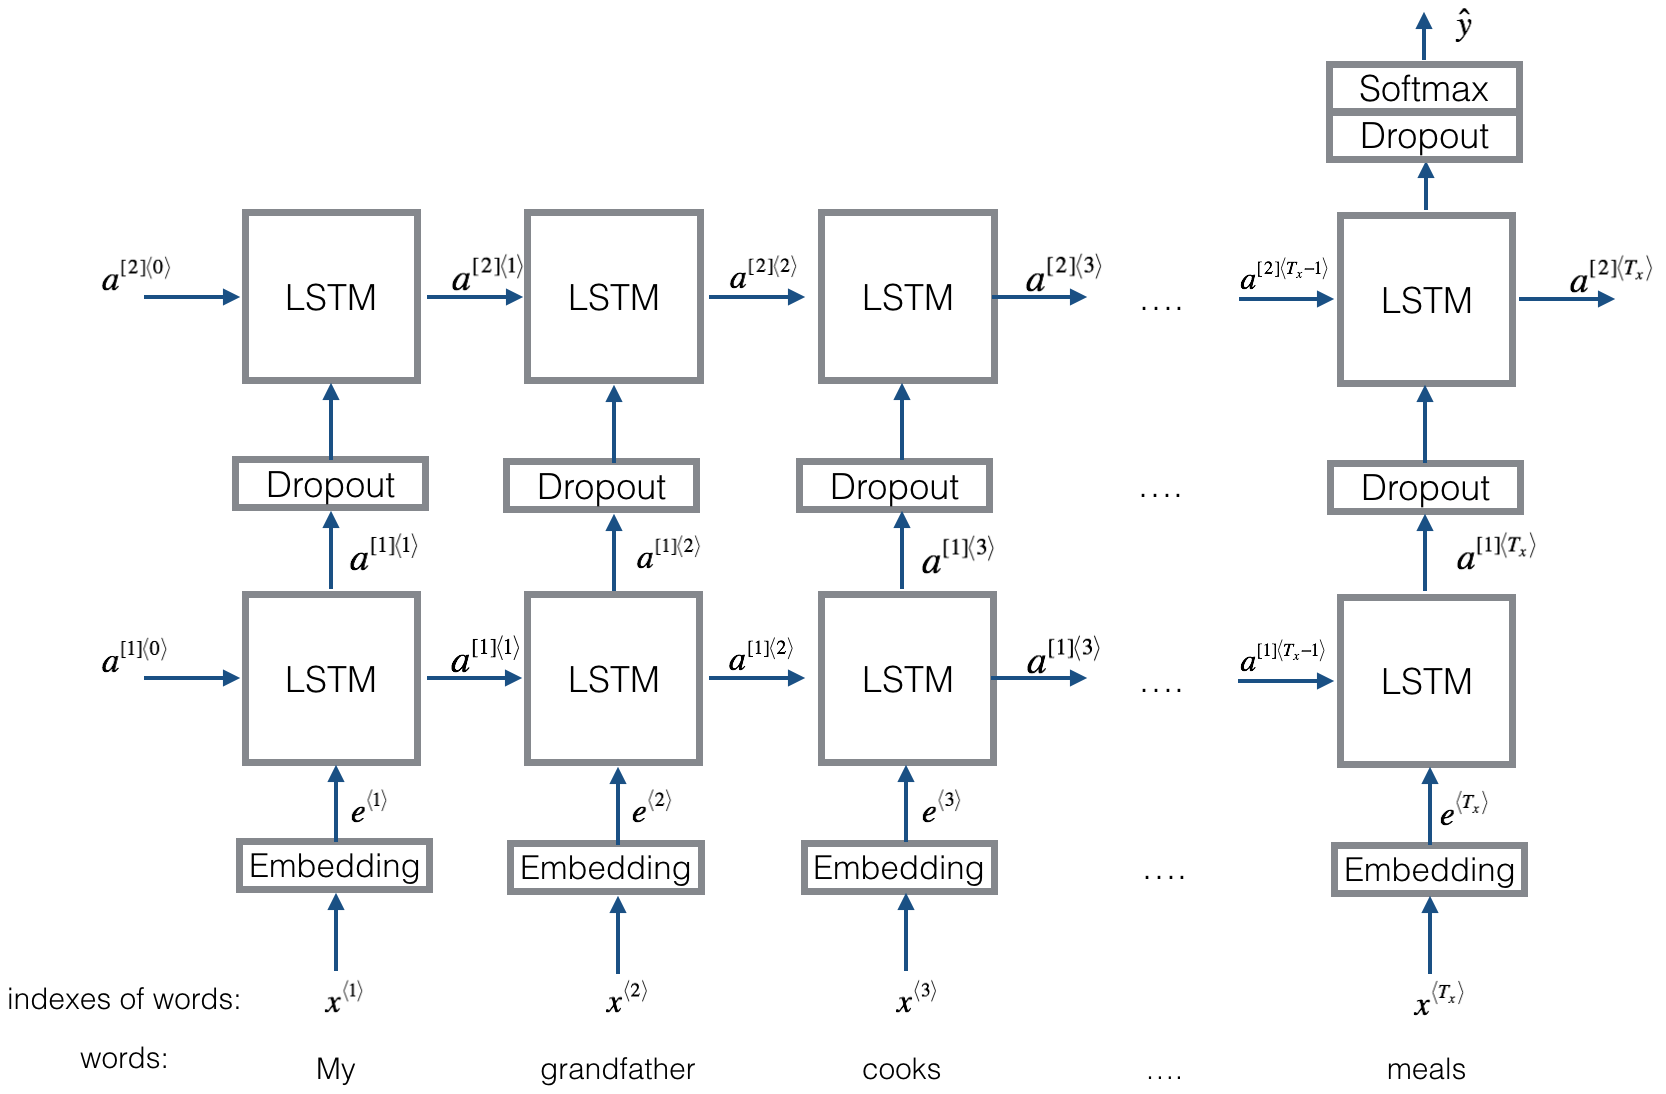

The thing  with keras and infact with most deep learning frameworks is that for a given batch we want fixed length input. Say is one senetecne length is 4 and other is 6, we would need different time steps for the evaluation, which is somewhat not possible.Solution is to pad the input sentence to the length of maximum sentence

In [68]:
def sentences_to_indices(X, word_to_index, max_len):
    '''Converts array of sentences into array of indices'''
    '''X is array of sentences of shape (m,1)'''
    a=np.zeros((X.shape[0],max_len))
    for i in range(X.shape[0]):
        listofwords=X[i].lower().split()
        for j in range(len(listofwords)):
            a[i][j]=word_to_index[listofwords[j]]
    return a     
   

Making the Embedding() layer in Keras, using pre-trained word vectors. After this layer is built,  will pass the output of sentences_to_indices() to it as an input, and the Embedding() layer will return the word embeddings for a sentence. So, we can think of embedding layers as taking an input of shape(batchsize,maxlen) and outputting of shape(batchsize,maxlen,lengthofwordvector(in our case 50))

### Making  an embedding layer in Keras

It's like we are making a matrix in which corresponding to each index we have a word vector(of length 50). so, if we have 4lakh words than matrix should be of shape (4lakh,50)

In [69]:
maxLen = len(max(X_train, key=len).split())#maximum length of sentence

In [70]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    '''Will create an embedding layer and will load it with pretrained word embeddings'''
    vocab_len=len(word_to_index)+1  #This will be row of embedded matrix
    word_dim=word_to_vec_map['apple'].shape[0]
    emb_matrix = np.zeros((vocab_len,word_dim))#Initializing embedded matrix
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
    embedding_layer = Embedding(vocab_len, word_dim,input_length=maxLen)
    
    #Building the layer
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

Note that our model will require input to be of shape (m,maxlen) and embedding layer will convert that to (m,maxlen,50). Now, see that embedding layer is outputting the same dimesion as expected by LSTM i.e. (m,tx,no of features)

### Defining model 

In [73]:
model=Sequential()
embedding_layer = pretrained_embedding_layer(words_to_vec,word_to_index)
model.add(embedding_layer)
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(5,activation='softmax'))
model.add(Activation('softmax'))

In [74]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_9 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
_________________________________________________________________
activation_5 (Activation)    (None, 5)                 0         
Total para

In [75]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Since our model expects "X" to be of shape (m,max_len).Convert 'x' to required shape

In [76]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)

In [79]:
model.fit(X_train_indices, Y_oh_train, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
132/132 [==============================] - 4s 31ms/step - loss: 1.5766 - acc: 0.3258
Epoch 2/50
132/132 [==============================] - 4s 30ms/step - loss: 1.5604 - acc: 0.2955
Epoch 3/50
132/132 [==============================] - 4s 30ms/step - loss: 1.5368 - acc: 0.3788
Epoch 4/50
132/132 [==============================] - 4s 30ms/step - loss: 1.5343 - acc: 0.3712
Epoch 5/50
132/132 [==============================] - 4s 30ms/step - loss: 1.5129 - acc: 0.3939
Epoch 6/50
132/132 [==============================] - 4s 30ms/step - loss: 1.4762 - acc: 0.4015
Epoch 7/50
132/132 [==============================] - 4s 30ms/step - loss: 1.4215 - acc: 0.4848
Epoch 8/50
132/132 [==============================] - 4s 31ms/step - loss: 1.3644 - acc: 0.5530
Epoch 9/50
132/132 [==============================] - 4s 30ms/step - loss: 1.3345 - acc: 0.5682
Epoch 10/50
132/132 [==============================] - 4s 32ms/step - loss: 1.3334 - acc: 0.5758
Epoch 11/50
132/132 [==================

In [81]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
loss, acc = model.evaluate(X_test_indices, Y_oh_test)
print("Test accuracy = ", acc)

56/56 [==============================] - 0s 2ms/step
('Test accuracy = ', 0.7678571513720921)
